In [1]:
import math, matplotlib.pyplot as plt, operator, torch
from functools import partial
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [2]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

## Background

In this blog post I'll walk through the Mean Shift Clustering algorithm as introduced [in Lesson 12 of the fastai course (Part 2)](https://github.com/fastai/course22p2/blob/master/nbs/02_meanshift.ipynb).

The algorithm:

> - For each data point `x` in the sample `X`, find the distance between that point `x` and every other point in `X`
- Create weights for each point in `X` by using the Gaussian kernel of that point's distance to `x`
- This weighting approach penalizes points further away from `x`
- The rate at which the weights fall to zero is determined by the bandwidth, which is the standard deviation of the Gaussian
- Update `x` as the weighted average of all other points in `X`, weighted based on the previous step

![Conceptual visual showing the mean shift clustering algorithm weighting by distance. The red point is `x`.](1.png)

<iframe width="560" height="315" src="https://www.youtube.com/embed/kfl-cUz9iWw?si=nL8PUaUBmqQcYJMk" title="YouTube video player" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture; web-share" referrerpolicy="strict-origin-when-cross-origin" allowfullscreen></iframe>

## Generating Clearly Clustered Data

An important point: we start by creating fake data such that it is knowingly clustered around a set of centroids we can then compare to the final clustering result.

In [3]:
n_clusters=6
n_samples =250

In [4]:
centroids = torch.rand(n_clusters, 2)*70-35

In [5]:
centroids.shape

torch.Size([6, 2])

In [6]:
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

We'll generate data around these 6 centroids using PyTorch's `MultivariateNormal` which:

> Creates a multivariate normal (also called Gaussian) distribution parameterized by a mean vector and a covariance matrix.

The covariance matrix in our case is a diagonal matrix with 5s on the diagonal.

We generate 250 samples for each mean vector (centroid).

In [7]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

In [8]:
torch.diag(tensor([5.,5.]))

tensor([[5., 0.],
        [0., 5.]])

From Gemini this covariance matrix shows:

> - **No Correlation**: The two variables are uncorrelated (covariance is 0.0). For a `MultivariateNormal` distribution, this implies they are independent.
- **Equal Variance**: Both variables have the same variance of 5.0.
- **Shape**: If used in a 2D MultivariateNormal distribution, this will produce a circular cloud of data points, equally spread along both the X and Y axes.

In [9]:
coords = MultivariateNormal(centroids[0], torch.diag(tensor([5.,5.]))).sample((n_samples,))
coords.shape

torch.Size([250, 2])

We see how the `MultivariateNormal` distribution samples are spread out in a circular shape around the mean, with the density of samples decreasing as you move further away from the centroid.

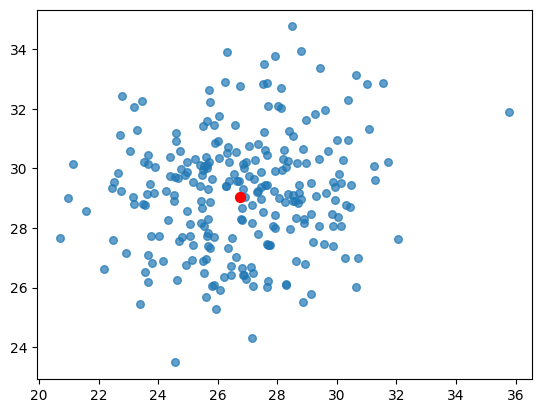

In [10]:
plt.scatter(coords[:,0], coords[:,1], alpha=0.7, s=30);
plt.scatter(centroids[0][0], centroids[0][1], c = 'red', s=50);
ax = plt.gca() # Get current axes
ax.set_aspect('equal', adjustable='box')

We sample from the `MultivariateNormal` distribution for all six of our centroids and concatenate the result.

In [11]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [12]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*centroid, markersize=8, marker="x", color='k', mew=2)

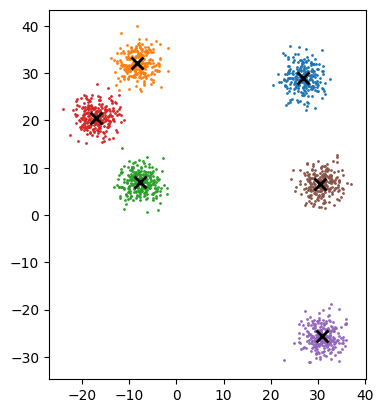

In [13]:
plot_data(centroids, data, n_samples);

## Generating Sample Weights

With our data generated, we'll now prepare for the third step in the algorithm: _create weights_.

> Create weights for each point in X by using the Gaussian kernel of that point's distance to x

We'll start by defining a function which takes some distance `d` and some bandwidth `bw` and returns the gaussian normal output given these two inputs. This output will be our _weights_:

In [15]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw))**2) / (bw*math.sqrt(2*math.pi))

(Wikipedia) the probability density function of the normal distribution is given by:

$$f(x)={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}$$

In our case, `d` (the distance from a point in X to another point in X) is equivalent in this function to $x-\mu$, and bandwidth `bw` is the standard deviation $\sigma$.

As bandwidth increases, the gaussian distribution flattens out (i.e. weights decay slower as distance increases).

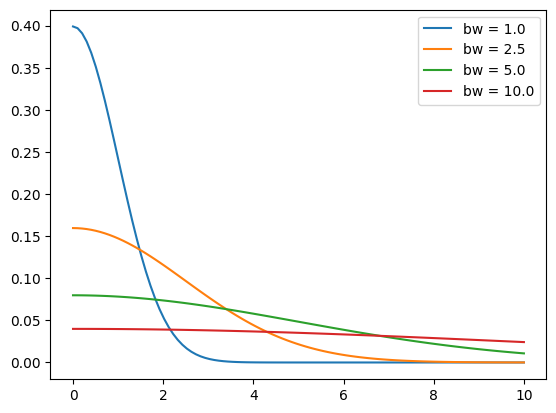

In [16]:
x = torch.linspace(0,10,100)
plt.plot(x, gaussian(x, bw=1.0), label='bw = 1.0')
plt.plot(x, gaussian(x, bw=2.5), label='bw = 2.5')
plt.plot(x, gaussian(x, bw=5.0), label='bw = 5.0')
plt.plot(x, gaussian(x, bw=10.0), label='bw = 10.0')
plt.legend();

We can also try to use a simpler linear function for our weights.

In [17]:
def tri(d, i): return (-d+i).clamp_min(0)/i

Mathematically, this calculates `max(0, (i - d) / i)` which is equivalent to `max(0, 1 - d / i)`

`clamp_min` ensures that the value of `-d+i` does not go below `0`. `i` becomes the d-intercept.

As `i` increases, the slope decreases, and weights decay slower as distance increases.

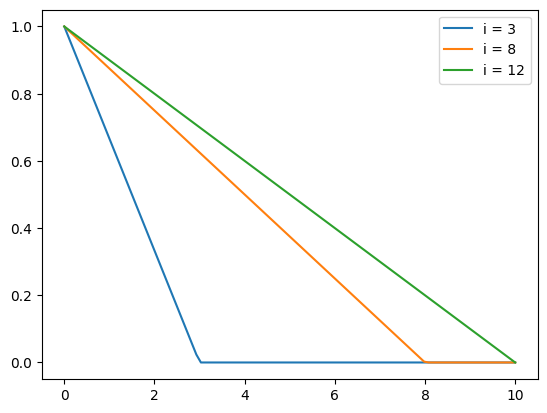

In [18]:
x = torch.linspace(0,10,100)
plt.plot(x, tri(x,i=3), label='i = 3')
plt.plot(x, tri(x,i=8), label='i = 8')
plt.plot(x, tri(x,i=10), label='i = 12')
plt.legend();

## Implementing the Full Algorithm

> - For each data point x in the sample X, find the distance between that point x and every other point in X (`d = f(x-X)`)
- Create weights for each point in X by using the Gaussian kernel of that point's distance to x (`weights = gaussian(d)`)
- Update x as the weighted average of all other points in X, weighted based on the previous step (`x = weighted_avg(weights, X)`)

Since we are going to update the data after each step of the algorithm, we clone the data to start. As a reminder, these 1500 coordinates come from 250 `MultivariateNormal` samples given 6 centroids as the mean.

In [19]:
X = data.clone()
x = X[0]
x

tensor([29.764, 26.161])

In [20]:
X.shape, x.shape

(torch.Size([1500, 2]), torch.Size([2]))

We now calculate _the distance between that point x and every other point in X_. Since `x` and `X` share a dimension `2`, we can just subtract and PyTorch will use broadcasting.

In [21]:
(x-X).shape

torch.Size([1500, 2])

In [22]:
(x-X)[0] # subtracting the first point from itself

tensor([0., 0.])

In [23]:
x

tensor([29.764, 26.161])

In [24]:
X[:5]

tensor([[29.764, 26.161],
        [28.472, 30.493],
        [27.549, 23.130],
        [23.500, 26.879],
        [27.327, 28.650]])

In [25]:
(x-X)[:5]

tensor([[ 0.000,  0.000],
        [ 1.292, -4.333],
        [ 2.215,  3.030],
        [ 6.264, -0.718],
        [ 2.437, -2.489]])

We'll use Euclidean distance, which is the square root of the sum (across the columns, or rather across coordinates) of the difference in coordinates squared.

In [26]:
((x-X)**2).shape

torch.Size([1500, 2])

In [27]:
((x-X)**2)[:5]

tensor([[ 0.000,  0.000],
        [ 1.668, 18.772],
        [ 4.906,  9.184],
        [39.239,  0.515],
        [ 5.939,  6.196]])

Summing across the columns to get $x^2+y^2$.

In [29]:
((x-X)**2).sum(1).shape

torch.Size([1500])

In [30]:
((x-X)**2).sum(1)[:5]

tensor([ 0.000, 20.440, 14.089, 39.754, 12.134])

In [31]:
dist = ((x-X)**2).sum(1).sqrt()
dist.shape

torch.Size([1500])

In [32]:
dist[:5]

tensor([0.000, 4.521, 3.754, 6.305, 3.483])

Since we are performing elementwise multiplication following by a summation, we can use Einstein Summation:

In [33]:
torch.einsum('ij,ij->i', x-X, x-X).sqrt()

tensor([ 0.000,  4.521,  3.754,  ..., 21.305, 21.850, 21.958])

We can also use matrix multiplication, though IIUC, you have to pluck out the values on the resulting matrix's diagonal to get the elementwise product between `x-X` and itself.

In [34]:
(x-X).shape, (x-X).T.shape

(torch.Size([1500, 2]), torch.Size([2, 1500]))

In [35]:
res = (x-X) @ (x-X).T
res.shape

torch.Size([1500, 1500])

In [36]:
torch.diag(res)

tensor([  0.000,  20.440,  14.089,  ..., 453.898, 477.408, 482.169])

In [37]:
torch.diag(res).sqrt()

tensor([ 0.000,  4.521,  3.754,  ..., 21.305, 21.850, 21.958])

We now _create weights for each point in X by using the Gaussian kernel of that point's distance to x_.

In [38]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.031,     0.052,  ...,     0.000,     0.000,     0.000])

We have 1500 weights, one for each distance between our current point `x` and all of the points in `X`.

In [39]:
weight.shape

torch.Size([1500])

We can now move on to the last step in the algorithm: _update x as the weighted average of all other points in X, weighted based on the previous step_.

The weighted average is the elementwise product of the `weights` and `X`, summed down the rows (two get 2 coordinates) and then divided by the sum of the weights.

Starting from the last dimension, `weight` and `X` do not have compatible dimensions (1500 is not 2 or 1), so we have to add a unit axis to `weight` to allow for broadcasting.

In [42]:
X.shape

torch.Size([1500, 2])

In [43]:
weight*X

RuntimeError: The size of tensor a (1500) must match the size of tensor b (2) at non-singleton dimension 1

In [44]:
weight[:,None].shape

torch.Size([1500, 1])

In [46]:
weight[:,None]*X

tensor([[    4.750,     4.175],
        [    0.886,     0.948],
        [    1.424,     1.196],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

We then sum down the rows to get two coordinates:

In [48]:
(weight[:,None]*X).sum(0)

tensor([296.880, 291.612])

This is the same as applying the weights to each column separately:

In [49]:
(weight * X[:,0]).sum(), (weight * X[:,1]).sum()

(tensor(296.880), tensor(291.612))

We then divide by the sum of the weights to get our final, updated `x`:

In [50]:
(weight[:,None]*X).sum(0)/weight.sum()

tensor([28.118, 27.619])

Wrapping this up into a function for each `x` in `X` we calculate the distance between `x` and all points in `X`, calculate the weights for those distances and replace `x` with the weighted average of those weights and all the points.

In [51]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [52]:
X = data.clone()
x = X[0]
x

tensor([29.764, 26.161])

In [53]:
one_update(X)

In [55]:
X[0]

tensor([28.118, 27.619])

We can now wrap up into a `meanshift` function where it performs `n` such updates.

In [57]:
def meanshift(data, n=5):
    X = data.clone()
    for it in range(n): one_update(X)
    return X

In [68]:
%time X=meanshift(data)

CPU times: user 1.39 s, sys: 3.12 ms, total: 1.4 s
Wall time: 1.42 s


We can now see that in 5 iterations, the weight updates have resulted in the points to converge at the original centroids!

In [69]:
def plot_data(centroids, data, n_samples, ax=None, alpha=4):
    if ax is None: _,ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box') # Add this line
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.plot(*centroid, markersize=8, marker="x", color='k', mew=2, alpha=1 - alpha*0.2)
        ax.scatter(samples[:,0], samples[:,1], s=1)

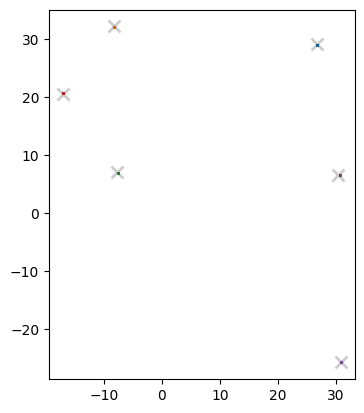

In [70]:
plot_data(centroids, X, n_samples)

## Animating the Algorithm

In [71]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [72]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids, X, n_samples, ax=ax, alpha=d)

We can visualize the "gravity" of the cluster centroids as the data points are "pulled in" via the weighted average.

In [73]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

## Running the Algorithm on the GPU

Instead of updating one data point at a time:

```python
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.sqrt(((x-X)**2).sum(1))
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()
```

What if we updates one batch at a time on the GPU?

In [74]:
bs=5
X = data.clone()
x = X[:bs]
x.shape,X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))

To calculate the distance between the two, we have to first subtract them. To do this subtraction, the current dimensions won't work (as 1500 is not compatible with 5):

In [75]:
x-X

RuntimeError: The size of tensor a (5) must match the size of tensor b (1500) at non-singleton dimension 0

Let's think about what we are trying to do here. We want to subtract from each point in the batch `x` every point in the full set `X`. So each pair of 1500 coordinates need to be subtracted from each pair of 5 coordinates.

I find it easier to start with "just making the dimensions work" for broadcasting.

In [76]:
x[None].shape, X[:,None].shape

(torch.Size([1, 5, 2]), torch.Size([1500, 1, 2]))

Going right to left: the last dimension matches (2), 1 is compatible with 5 and 1 is compatible with 1500. We can subtract these two tensors.

In [77]:
(x[None]-X[:,None]).shape

torch.Size([1500, 5, 2])

The result is 1500 sets of 5 coordinate pairs. The 5 coordinate pairs are the difference between the coordinates in batch `x` and a coordinate in `X`.

Checking this manually, let's take the first point in `x`.

In [78]:
x[0,:].shape

torch.Size([2])

The dimension of 2 is compatible with the last dimension of `X` so we can subtract these shapes directly.

In [79]:
(x[0,:] - X).shape

torch.Size([1500, 2])

This difference is equal to the first item of the batch in the broadcasted version.

In [81]:
((x[0,:] - X) == (x[None]-X[:,None])[:,0,:]).float().mean()

tensor(1.)

With that under my belt, I'll now visualize the broadcasting operation to better understand why the dimensions "just work".

Adding the unit axis to `x` (our batch of 5 coordinates) as the first dimension is not as intuitive visually as it just adds a pair of brackets to the outside of the 5 coordinates. However, what this does is allow the set of 5 coordinates (as a group) to be broadcasted across another dimension of any size.

In [82]:
x

tensor([[29.764, 26.161],
        [28.472, 30.493],
        [27.549, 23.130],
        [23.500, 26.879],
        [27.327, 28.650]])

In [83]:
x[None]

tensor([[[29.764, 26.161],
         [28.472, 30.493],
         [27.549, 23.130],
         [23.500, 26.879],
         [27.327, 28.650]]])

Adding the unit axis as the second dimension to `X` (our full set of 1500 coordinates) is more visually intuitive---we've added a pair of brackets around each pair of coordinates, making them broadcastable to any other dimension.

In [84]:
X

tensor([[29.764, 26.161],
        [28.472, 30.493],
        [27.549, 23.130],
        ...,
        [32.214,  4.997],
        [30.872,  4.339],
        [28.347,  4.248]])

In [86]:
X[:,None]

tensor([[[29.764, 26.161]],

        [[28.472, 30.493]],

        [[27.549, 23.130]],

        ...,

        [[32.214,  4.997]],

        [[30.872,  4.339]],

        [[28.347,  4.248]]])

So our batch of 5 coordinates `x` can now be broadcasted as many times as needed, and each pair of coordinates in `X` can also be broadcasted as many times as needed.

The result: each pair of coordinates in `X` is broadcasted 5 times so they can be subtracted from each pair of coordinates in the batch. And the batch is broadcasted 1500 times so that each pair of coordinates in `X` can be subtracted from it.

Looking at each of those statements visually:

![Each pair of coordinates in X is broadcasted 5 times so they can be subtracted from each pair of coordinates in the batch](2.png)

![The batch `x` is broadcasted 1500 times so that each pair of coordinates in `X` can be subtracted from it.](3.png)

With the understood, I can now continue with the batched implementation of the algorithm. With the correct shapes, thanks to adding unit axes, we can create a batched distance function:

In [88]:
def dist_b(a,b): return (((a[None]-b[:,None])**2).sum(2)).sqrt()

In [90]:
dist_b(x,X).shape

torch.Size([1500, 5])

We now have 5 distances for each of the 1500 items in the dataset.

In [91]:
dist_b(x,X)

tensor([[ 0.000,  4.521,  3.754,  6.305,  3.483],
        [ 4.521,  0.000,  7.421,  6.148,  2.170],
        [ 3.754,  7.421,  0.000,  5.518,  5.524],
        ...,
        [21.305, 25.769, 18.724, 23.553, 24.152],
        [21.850, 26.264, 19.083, 23.714, 24.568],
        [21.958, 26.246, 18.899, 23.144, 24.423]])

The first row are the distances between the first coordinate pair in `X` and each of the coordinate pairs in the batch. The second row contains distances between the _second_ coordinate pair in `X and each of the batch coordinate pairs. And so on an so forth for 1500 rows. Each with 5 distances representing the distances to the batch items.

We pass this tensor into our `gaussian` and get back our weights.

In [92]:
weight = gaussian(dist_b(x, X), 2.5)
weight, weight.shape

(tensor([[    0.160,     0.031,     0.052,     0.007,     0.060],
         [    0.031,     0.160,     0.002,     0.008,     0.109],
         [    0.052,     0.002,     0.160,     0.014,     0.014],
         ...,
         [    0.000,     0.000,     0.000,     0.000,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.000],
         [    0.000,     0.000,     0.000,     0.000,     0.000]]),
 torch.Size([1500, 5]))

In [93]:
weight[:5]

tensor([[0.160, 0.031, 0.052, 0.007, 0.060],
        [0.031, 0.160, 0.002, 0.008, 0.109],
        [0.052, 0.002, 0.160, 0.014, 0.014],
        [0.007, 0.008, 0.014, 0.160, 0.038],
        [0.060, 0.109, 0.014, 0.038, 0.160]])

Looking at the first 5 rows of our weights we have a square matrix---the weights between the first 5 points (i.e. the points in our batch). From row 6 we have the weights from these 5 points to point 6.

Technically we could have a batch size of 1500 and the weights in full would be a square matrix.

Now for the fun part! Understanding broadcasting so we can perform the weighted average, which starts with an elementwise multiplication betwee the weights and the data points.

Conceptually we want something like this (example shown for the first two batch items' weights)

![Multiplying weights by `X` and summing down the columns to get a pair of coordinates](4.png)

In [94]:
weight.shape,X.shape

(torch.Size([1500, 5]), torch.Size([1500, 2]))

The last dimension of each tensor is not compatible (5 and 2). We need to introduce a unit axis so that we can broadcast the 5 batch items to each of the 1500 coordinate pairs.

We'll again start by "just making the dimensions work", adding a unit axis to the end of `weight` and the beginning of `X`. Scanning the dimensions left to right: 1 and 2 are compatible, 5 and 1 are compatible, 1500 and 1500 are compatible.

In [96]:
weight[...,None].shape, X[:,None].shape

(torch.Size([1500, 5, 1]), torch.Size([1500, 1, 2]))

In [98]:
(weight[...,None]*X[:,None]).shape

torch.Size([1500, 5, 2])

We'll sum down the first dimension to get 5 pairs of coordinate.

In [100]:
(weight[...,None]*X[:,None]).sum(0)

tensor([[296.880, 291.612],
        [476.489, 514.066],
        [140.263, 134.432],
        [278.256, 307.251],
        [577.373, 615.003]])

The first pair of coordinates `[296.880, 291.612]` are the sum of the first pair of elementwise products in each set of 5 batched items in each of the 1500 rows.

In [102]:
(weight[...,None]*X[:,None])

tensor([[[    4.750,     4.175],
         [    0.926,     0.814],
         [    1.539,     1.352],
         [    0.197,     0.174],
         [    1.799,     1.581]],

        [[    0.886,     0.948],
         [    4.544,     4.866],
         [    0.055,     0.059],
         [    0.221,     0.237],
         [    3.117,     3.338]],

        [[    1.424,     1.196],
         [    0.054,     0.045],
         [    4.396,     3.691],
         [    0.385,     0.323],
         [    0.383,     0.321]],

        ...,

        [[    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000]],

        [[    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000]],

        [[    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000,     0.000],
         [    0.000

In [101]:
(weight[...,None]*X[:,None])[:, 0,:]

tensor([[    4.750,     4.175],
        [    0.886,     0.948],
        [    1.424,     1.196],
        ...,
        [    0.000,     0.000],
        [    0.000,     0.000],
        [    0.000,     0.000]])

In [103]:
(weight[...,None]*X[:,None])[:, 0,:].sum(0)

tensor([296.880, 291.612])

Looking at this visually:

![Elementwise multiplication of `weight[...,None]` and `X[None]` followed by `sum(0)` down the columns](5.png)

In [104]:
num = (weight[...,None]*X[:,None]).sum(0)
num.shape

torch.Size([5, 2])

In [105]:
num

tensor([[296.880, 291.612],
        [476.489, 514.066],
        [140.263, 134.432],
        [278.256, 307.251],
        [577.373, 615.003]])

Since we are performing an elementwise multiplication follow by a sum, we can use Einstein Summation!

In [106]:
torch.einsum('ij,ik->jk', weight, X)

tensor([[296.880, 291.612],
        [476.489, 514.066],
        [140.263, 134.432],
        [278.256, 307.251],
        [577.373, 615.003]])

Similary, we can also use matrix multiplication:

In [107]:
weight.T@X

tensor([[296.880, 291.612],
        [476.489, 514.066],
        [140.263, 134.432],
        [278.256, 307.251],
        [577.373, 615.003]])

To get our weighted average, we divide by the sum of weights.

In [108]:
div = weight.sum(0, keepdim=True).T
div.shape

torch.Size([5, 1])

We want to perform an elementwise division (each coordinate needs to be divided by the sum of weights) so we `keepdim`.

In [109]:
div

tensor([[10.558],
        [17.315],
        [ 5.167],
        [10.983],
        [21.347]])

In [110]:
num/div

tensor([[28.118, 27.619],
        [27.519, 29.689],
        [27.145, 26.016],
        [25.334, 27.974],
        [27.047, 28.810]])

Wrapping this into a new `meanshift` function. Each step now performs batched calculations.

In [112]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X[s], X), 2.5)
            div = weight.sum(0, keepdim=True).T
            X[s] = weight.T@X/div
    return X

We can now utilize the GPU (since we're doing batched calculations)

In [113]:
data = data.cuda()

In [114]:
X = meanshift(data).cpu()

In [117]:
%timeit -n 5 _=meanshift(data, 1250).cpu()

5.37 ms ± 43.1 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


Using the GPU we cut the execution time from 1.5 seconds to 6 milliseconds to achieve the same result.

In [118]:
1500/6

250.0

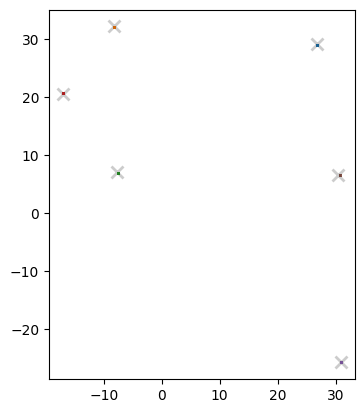

In [119]:
plot_data(centroids, X, n_samples)

If we perform the unbatched calculation using the GPU, we don't see this speed up.

In [121]:
def meanshift(data, n=5):
    X = data.clone()
    for it in range(n): one_update(X)
    return X

In [122]:
%time X = meanshift(data.cuda()).cpu()

CPU times: user 1.33 s, sys: 969 µs, total: 1.33 s
Wall time: 1.33 s


## Closing Thoughts

Implementing mean shift clustering become an exercise in understanding broadcasting! The weighted average (elementwise multiplication followed by a summation down an axis) is well suited for broadcasting, Einstein Summation and matrix multiplication. Seeing the relationships between dimensions, and seeing how adding unit axes in a particular spot to allow for broadcasting gave me a deeper understanding of how tensor calculations work. We also saw a clear example of how the GPU only gives you a speedup if you perform batch operations on it.

I'm trying to grow my YouTube channel so if you're interesting in this type of content, [please subscribe!](https://www.youtube.com/@vishal_learner)